In [961]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from astropy.table import Table , vstack
import os
from matplotlib.animation import FuncAnimation
from ipywidgets import interact, FloatSlider, Layout
import scipy
from scipy.optimize import curve_fit
import scipy.optimize as optimize
import statistics as stat
import scipy.integrate as integrate
import ugradio
from datetime import datetime
import tarfile
from astropy.io import fits
import glob
%matplotlib notebook

# Extracting Data

In [2]:
path = 'C:/Users/Big_h/Lab 4 Data/Basically Full Galaxy'
pattern = '*.fits'

files = glob.glob(path + '/' + pattern)

avg_data = np.empty(shape = (len(files), 8192))

In [3]:
for index, file in enumerate(files):
    f= fits.open(file)
    data = []
    for i in range(1, len(f)):
        d = f[i].data['auto0_real']
        data.append(d)
    data = np.array(data)
    avg = np.mean(data, axis = 0)
    avg_data[index, :] = avg

In [973]:
f[0].header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
NSPEC   =                   20 / Number of spectra recorded                     
BOFFILE = 'spec_ds8_8192.bof'  / FPGA binary code                               
MODE    = 'spec    '           / Spectrometer mode                              
FPGA    =          192000000.0 / FPGA clock speed (Hz)                          
IADC    =          768000000.0 / iADC clock speed (Hz)                          
DOWNSAMP=                    8 / ADC downsampling period.                       
SAMPRATE=           24000000.0 / Downsampled clock speed (Hz)                   
BW      =           12000000.0 / Bandwidth of spectra (Hz)                      
NCHAN   =                 81

In [4]:

longitudes = []
longdict = {}
for filename in files:
    with fits.open(filename) as hdul:
        longitude_data = hdul[0].header['L']
        longdict[longitude_data] = filename
        longitudes.append(longitude_data)

longitudes = np.array(longitudes)

print(longitudes.shape)

longitudes

(250,)


array([ -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,   2.,
         3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,  12.,  13.,
        14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,  22.,  23.,  24.,
        25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,  33.,  34.,  35.,
        36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,  44.,  45.,  46.,
        47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,  55.,  56.,  57.,
        58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,  66.,  67.,  68.,
        69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,  77.,  78.,  79.,
        80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,  88.,  89.,  90.,
        91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,  99., 100., 101.,
       102., 103., 104., 105., 106., 107., 108., 109., 110., 111., 112.,
       113., 114., 115., 116., 117., 118., 119., 120., 121., 122., 123.,
       124., 125., 126., 127., 128., 129., 130., 131., 132., 133., 134.,
       135., 136., 137., 138., 139., 140., 141., 14

# Deconvoluting Data

In [6]:
fft_freq=np.fft.fftshift(np.fft.fftfreq(8192,1/24))

freqs = np.linspace(144,156,8192) + 1270

gain = 13224.018793349653
tline=gain*avg_data
temp=tline-np.median(tline)

<IPython.core.display.Javascript object>


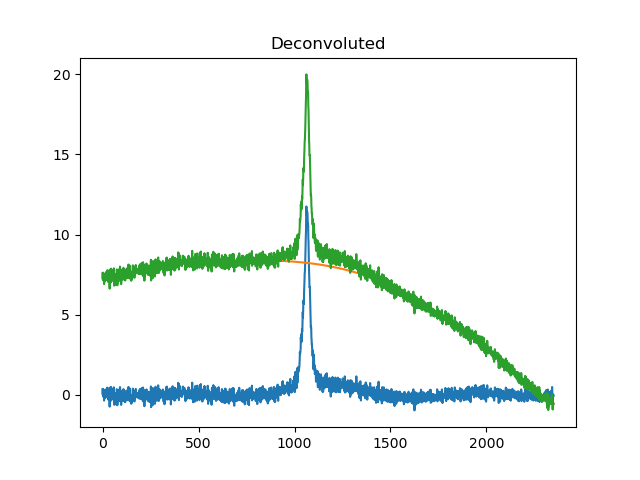

In [899]:
exclude_start = 4190
exclude_end = 4730

mask = np.ones_like(fft_freq, dtype=bool)
mask[exclude_start:exclude_end] = False
differences = []
fit_y_arr = []
for i in range(len(temp)):
    coeffs = np.polyfit(fft_freq[mask][3400:5750], temp[i][mask][3400:5750], 7)
    fit_y = np.polyval(coeffs, fft_freq[3400:5750])
    diff = temp[i][3400:5750]-fit_y
    differences.append(diff)
    fit_y_arr.append(fit_y)
differences = np.array(differences)
plt.figure()
plt.plot(differences[0])
plt.plot(fit_y_arr[0])
plt.plot(temp[0][3400:5750])
plt.title('Deconvoluted')
plt.show()

# Modeling

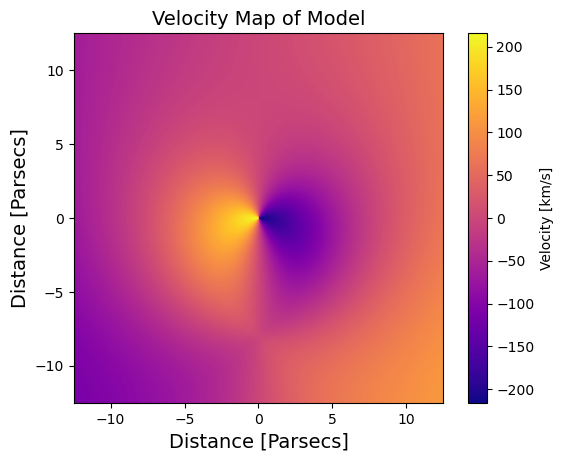

In [1079]:

x_arr = np.linspace(-12.5,12.5, 1000)
y_arr = np.linspace(-12.5,12.5, 1000)
earth_x = 0
earth_y = -8
X,Y = np.meshgrid(x_arr,y_arr)

vel_x = np.array(Y/np.sqrt(X**2 + Y**2)*220)
vel_y = np.array(-X/np.sqrt(X**2 + Y**2)*220)
vel_earth_x = earth_y/np.sqrt(earth_y**2)*220

dx  =X-0
dy = Y--8

vel_x_adjust = vel_x - vel_earth_x
vel = vel_x_adjust, vel_y
r_vector = dx,dy

mag_r = (np.sqrt(dx**2+dy**2))
mag_r_x_c = mag_r*3e5

dx_unit = dx/mag_r
dy_unit = dy/mag_r

vel_away = vel_x_adjust*dx_unit + vel_y*dy_unit

L_model_rad = np.arctan2(-dx,dy)
L_model = np.rad2deg(L_model_rad) 

plt.figure()
plt.imshow(vel_away, origin = 'lower', cmap = 'plasma', extent = [-12.5,12.5,-12.5,12.5])
plt.colorbar(label = 'Velocity [km/s]')
plt.title('Velocity Map of Model', fontsize = 14)
plt.xlabel('Distance [Parsecs]', fontsize = 14)
plt.ylabel('Distance [Parsecs]', fontsize = 14)
plt.show()

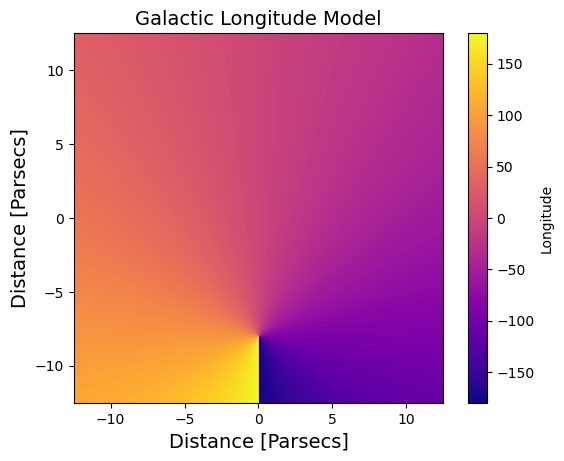

In [1078]:
plt.figure()
plt.imshow(L_model, origin='lower', cmap='plasma', extent = [-12.5,12.5,-12.5,12.5])
plt.colorbar(label = 'Longitude')
plt.title('Galactic Longitude Model', fontsize = 14)
plt.xlabel('Distance [Parsecs]', fontsize = 14)
plt.ylabel('Distance [Parsecs]', fontsize = 14)
#plt.savefig('GLong.png',format='png',dpi=400)
plt.show()

<IPython.core.display.Javascript object>


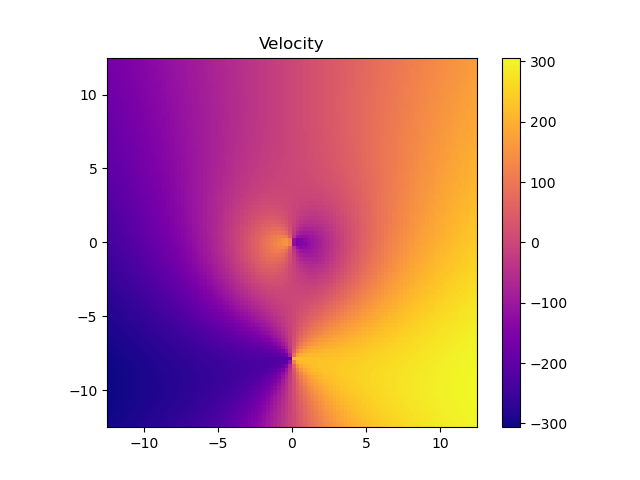

In [839]:
plt.figure()
plt.imshow(dnu, origin ='lower', extent = [-12.5,12.5,-12.5,12.5], cmap='plasma')
plt.colorbar()
plt.title('Velocity')
plt.show()

<IPython.core.display.Javascript object>


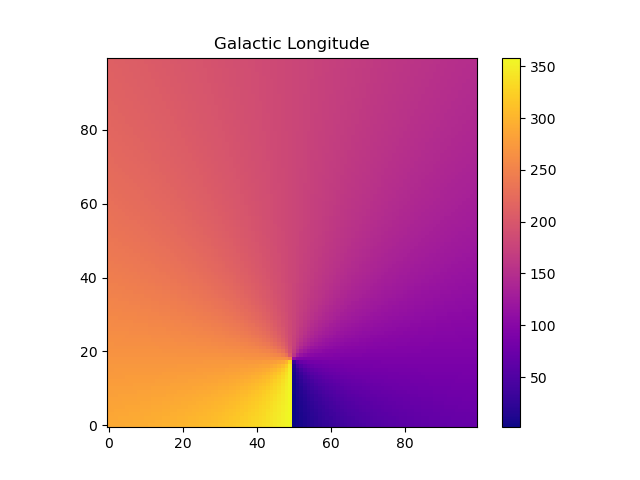

In [824]:
plt.figure()
plt.imshow(longitude, origin='lower', cmap='plasma')
plt.colorbar()
plt.title('Galactic Longitude')
plt.show()

# Data Representation

<IPython.core.display.Javascript object>


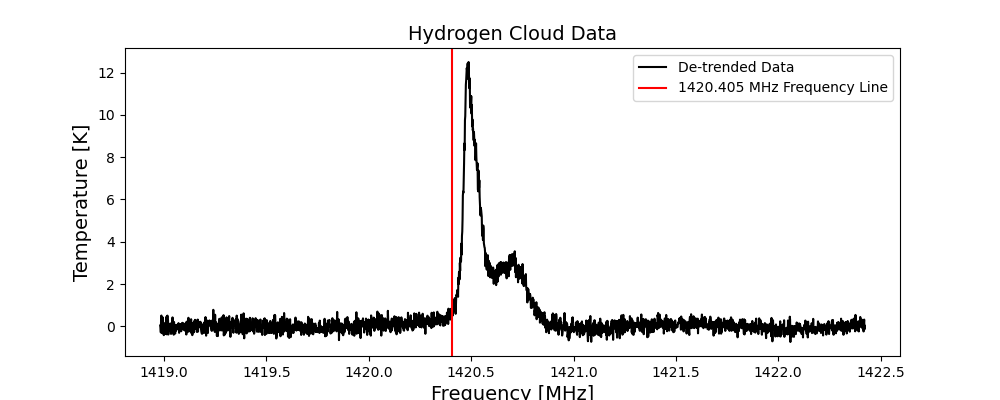

In [1004]:
LO = 1270 # MHz
freqs = np.linspace(144, 156, 8192) + LO # MHz
freqs_cut = freqs[3400:5750] # MHz

plt.figure(figsize =(10,4))
plt.plot(freqs_cut, differences[100], color = 'black', label='De-trended Data')
plt.axvline(1420.405, color = 'red', label = '1420.405 MHz Frequency Line')
plt.xlabel('Frequency [MHz]', fontsize = 14)
plt.ylabel('Temperature [K]', fontsize = 14)
plt.legend()
plt.title('Hydrogen Cloud Data', fontsize = 14)
plt.show()

<IPython.core.display.Javascript object>


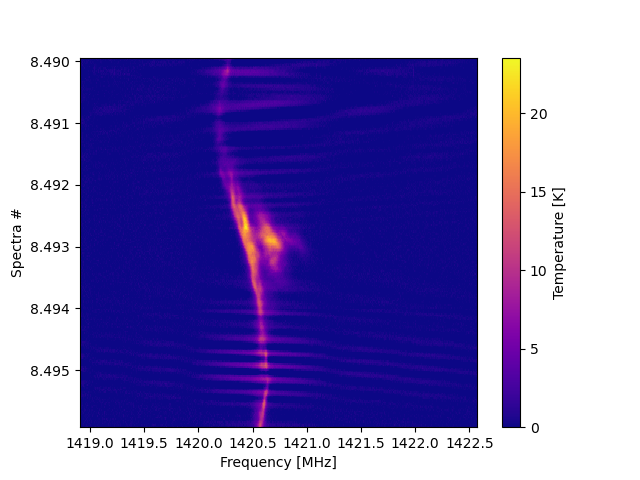

In [370]:
plt.figure()
plt.imshow(np.where(differences<0, 0, differences), aspect='auto', cmap='plasma', origin='lower', interpolation='nearest',
          extent=[freqs_cut[0], freqs_cut[-1], 8.5*np.sin(77), 8.5*np.sin(234)])
plt.colorbar(label='Temperature [K]')
plt.ylabel('Spectra #')
plt.xlabel('Frequency [MHz]')
plt.show()

# Functions for Milky Way Map

In [769]:
def find3(l,v):
    j = np.argmin(np.abs(longitudes-l))
    diff = longitudes[j]-l
    if np.abs(diff) > 5:
        return np.nan
#     x = zero_arr[int(longitudes[j])]
    x = differences[int(j)]
    nu = ((1420.405*(1-v/c)))
    ch = np.argmin(np.abs(freqs_cut-nu))
    temperature = x[ch]
    return temperature#, x, nu, ch
find3(-8, 85)

-0.2942455577909371

In [826]:
def pixle_v(a,b):
    return dnu[a,b]
def pixle_l(c,d):
    return longitude[c,d]
pixle_v(0,0), pixle_l(0,0), dnu[0,0], longitude[0,0]

(-320.3151132296663, 289.7988763545249, -320.3151132296663, 289.7988763545249)

In [939]:
arr = []
for i in range(len(L_model)):
    for j in range(len(vel_away)):
#         pixle_v(i,j)
#         pixle_l(i,j)
        mix = find3(pixle_l(i,j), pixle_v(i,j))
        arr.append(mix)
        
arr = np.array(arr)
# arr.reshape((25,25))
arr.shape = (1000,1000)
arr.shape
arr

array([[1.2328766 , 1.2328766 , 1.44986902, ...,        nan,        nan,
               nan],
       [1.2328766 , 1.2328766 , 1.44986902, ...,        nan,        nan,
               nan],
       [1.2328766 , 1.2328766 , 1.44986902, ...,        nan,        nan,
               nan],
       ...,
       [2.21893923, 2.33329844, 2.33329844, ...,        nan,        nan,
               nan],
       [2.21893923, 2.33329844, 2.33329844, ...,        nan,        nan,
               nan],
       [2.21893923, 2.33329844, 2.33329844, ...,        nan,        nan,
               nan]])

# Map of Milky Way in Radio

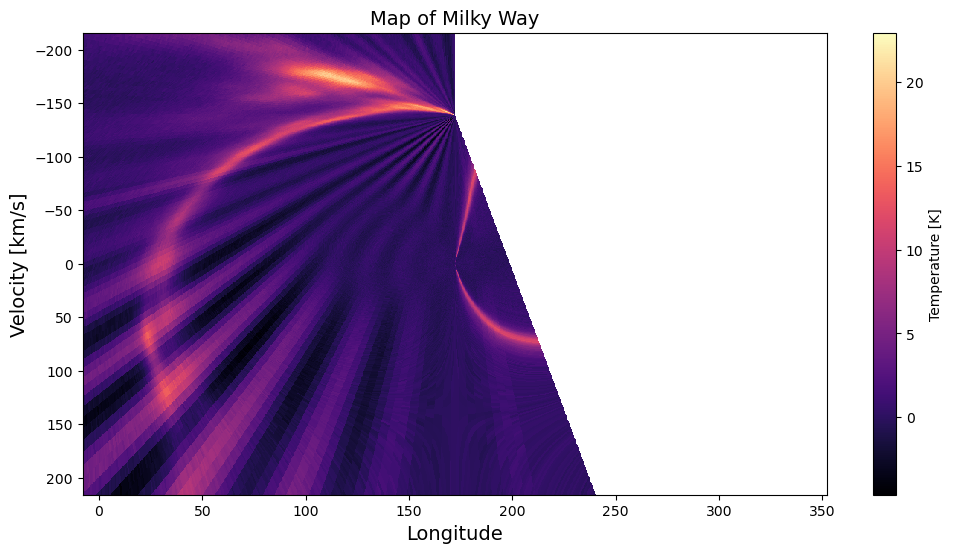

In [1076]:
%matplotlib inline
plt.figure(figsize = (12,6))
# plt.imshow(arr, origin = 'lower', aspect = 'auto', cmap = 'magma', interpolation = 'nearest', extent = [np.min(longitudes), np.max(longitudes), np.min(vel_away), np.max(vel_away)])
plt.imshow(arr, origin = 'lower', aspect = 'auto', cmap = 'magma', interpolation = 'nearest', extent = [-8, 352, np.min(vel_away), np.max(vel_away)])
# plt.imshow(arr, origin = 'lower', aspect = 'auto', cmap = 'magma', interpolation = 'nearest', extent = [np.min(vel_away), np.max(vel_away), np.max(longitudes), np.min(longitudes)])
plt.colorbar(label = 'Temperature [K]')
ax = plt.gca()
# ax.invert_xaxis()
ax.invert_yaxis()
plt.xlabel('Longitude', fontsize = 14)
plt.ylabel('Velocity [km/s]', fontsize = 14)
plt.title('Map of Milky Way', fontsize = 14)
plt.show()